In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autoreload

# Load Data

In [2]:
test_data = pd.read_csv('data/test_v2.csv')
train_data = pd.read_csv('data/train_v2.csv')

# Data Pipeline

In [3]:
%autoreload
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from include.DatetimeFromTimestamp import DatetimeFromTimestamp
from include.DataFrameDropper import DataFrameDropper
from include.DataFrameSelector import DataFrameSelector
from include.FilterNMostCommon import FilterNMostCommon


pipeline_normal = Pipeline([
    ('datetime_creator', DatetimeFromTimestamp()),
])

pipeline_1hot = Pipeline([
    ('dataframe_selector', DataFrameSelector(['product_category'])),
    ('filter_n_most_common', FilterNMostCommon(N=10, minRelFreq=0.01, attribute_name='product_category')),
    ('1hot_encoder', OneHotEncoder(sparse = False))
])

pipeline_analysis = FeatureUnion(transformer_list=[
    ('pipeline_normal', pipeline_normal),
    ('pipeline_1hot', pipeline_1hot),
])

In [4]:
train_data_treated = pipeline_analysis.fit_transform(train_data)
categories = pipeline_1hot.named_steps['1hot_encoder'].categories_
cols_train = list(train_data) + ['datetime'] + categories[0].tolist()

In [5]:
test_data_treated = pipeline_analysis.transform(test_data)
cols_test = list(test_data) + ['datetime'] + categories[0].tolist()

### Convert to DataFrame
Not necessary, we can always use the index from cols

In [9]:
train_data_treated = pd.DataFrame(train_data_treated, columns = cols_train)
train_data_treated.head()

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,...,C20,C21,amount,isfraud,datetime,28905ebd,3e814130,50e219e0,Other,f028772b
0,0,1413851531856,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,-1,79,184.09,0,2014-10-21 00:32:11.856000,1,0,0,0,0
1,1,1413851817483,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,100084,79,184.09,0,2014-10-21 00:36:57.483000,1,0,0,0,0
2,2,1413852597526,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,100084,79,184.09,0,2014-10-21 00:49:57.526000,1,0,0,0,0
3,3,1413851283020,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,100084,79,184.09,0,2014-10-21 00:28:03.020000,1,0,0,0,0
4,4,1413849935779,9166c161,fe8cc448,0569f928,ecad2386,a99f214a,320,50,2161,...,-1,157,196.98,0,2014-10-21 00:05:35.779000,0,0,0,1,0


In [10]:
test_data_treated = pd.DataFrame(test_data_treated, columns = cols_test)
test_data_treated.head()

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,...,C19,C20,C21,amount,datetime,28905ebd,3e814130,50e219e0,Other,f028772b
0,32263877,1414540656054,c4e18dd6,85f751fd,50e219e0,92f5800b,a99f214a,320,50,2424,...,161,100193,71,191.77,2014-10-28 23:57:36.054000,0,0,1,0,0
1,32263886,1414540614666,968765cd,6399eda6,f028772b,ecad2386,a99f214a,320,50,2526,...,167,100075,221,200.45,2014-10-28 23:56:54.666000,0,0,0,0,1
2,32263890,1414540692012,7e091613,e151e245,f028772b,ecad2386,a99f214a,320,50,1872,...,39,-1,23,169.51,2014-10-28 23:58:12.012000,0,0,0,0,1
3,32263895,1414540720045,7e091613,e151e245,f028772b,ecad2386,a99f214a,320,50,1872,...,39,-1,23,169.51,2014-10-28 23:58:40.045000,0,0,0,0,1
4,32263896,1414540641750,c4e18dd6,85f751fd,50e219e0,73206397,cc6c0613,320,50,2665,...,35,-1,221,191.77,2014-10-28 23:57:21.750000,0,0,1,0,0


# Overall analysis
* There are no null values in neither of the dataset, however, the are clearly values which are ***imputed to -1*** in the `C20` attribute as stated in Kaggle. These were probably nulls.
* 17% of the entries in the data are fraudulent.

In [56]:
test_data_treated.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32369524 entries, 0 to 32369523
Data columns (total 21 columns):
id                    32369524 non-null object
timestamp             32369524 non-null object
product_id            32369524 non-null object
product_department    32369524 non-null object
product_category      32369524 non-null object
card_id               32369524 non-null object
user_id               32369524 non-null object
C15                   32369524 non-null object
C16                   32369524 non-null object
C17                   32369524 non-null object
C18                   32369524 non-null object
C19                   32369524 non-null object
C20                   32369524 non-null object
C21                   32369524 non-null object
amount                32369524 non-null object
isfraud               32369524 non-null object
datetime              32369524 non-null object
28905ebd              32369524 non-null object
3e814130              32369524 non-null

In [54]:
train_data_treated.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32369524 entries, 0 to 32369523
Data columns (total 22 columns):
id                    32369524 non-null object
timestamp             32369524 non-null object
product_id            32369524 non-null object
product_department    32369524 non-null object
product_category      32369524 non-null object
card_id               32369524 non-null object
user_id               32369524 non-null object
C15                   32369524 non-null object
C16                   32369524 non-null object
C17                   32369524 non-null object
C18                   32369524 non-null object
C19                   32369524 non-null object
C20                   32369524 non-null object
C21                   32369524 non-null object
amount                32369524 non-null object
isfraud               32369524 non-null object
datetime              32369524 non-null object
28905ebd              32369524 non-null object
3e814130              32369524 non-null

### Value counts

In [32]:
print("Train: ")
fraud_counts = train_data['isfraud'].value_counts()
print(fraud_counts)
print(fraud_counts / train_data.shape[0])

Train: 
0    26819827
1     5549697
Name: isfraud, dtype: int64
0    0.828552
1    0.171448
Name: isfraud, dtype: float64


### Histograms

In [6]:
train_hist = train_data[['C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'amount']]

[]

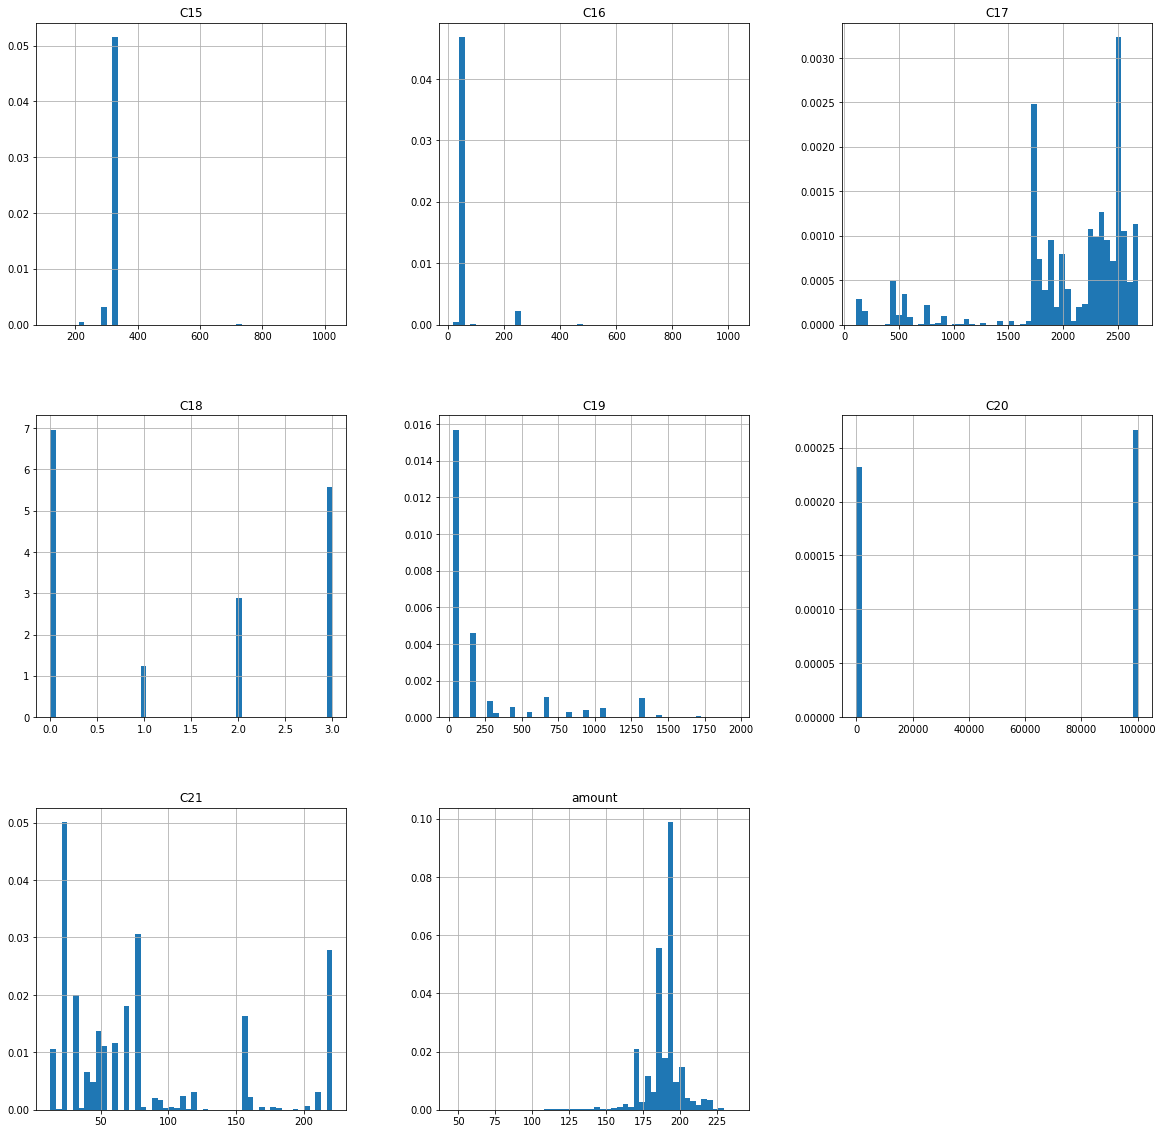

In [7]:
train_hist.hist(bins = 50, figsize=(20,20), density=True)
plt.plot()

In [63]:
train_data['C20'].value_counts()[:5]

-1         15059166
 100084     2033777
 100111     1448778
 100148     1374808
 100077     1306586
Name: C20, dtype: int64

## Fraud example

In [20]:
train_data_treated[train_data_treated['user_id'] == 'a99f214a']

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,...,amount,isfraud,datetime,28905ebd,3e814130,50e219e0,Other,f028772b,hour_of_day,day
0,0,1413851531856,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,184.09,0,2014-10-21 00:32:11.856000,1,0,0,0,0,0,21
1,1,1413851817483,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,184.09,0,2014-10-21 00:36:57.483000,1,0,0,0,0,0,21
2,2,1413852597526,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,184.09,0,2014-10-21 00:49:57.526000,1,0,0,0,0,0,21
3,3,1413851283020,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,184.09,0,2014-10-21 00:28:03.020000,1,0,0,0,0,0,21
4,4,1413849935779,9166c161,fe8cc448,0569f928,ecad2386,a99f214a,320,50,2161,...,196.98,0,2014-10-21 00:05:35.779000,0,0,0,1,0,0,21
5,5,1413849952572,bb1ef334,d6137915,f028772b,ecad2386,a99f214a,320,50,1899,...,188.02,0,2014-10-21 00:05:52.572000,0,0,0,0,1,0,21
6,6,1413852783753,25d4cfcd,8fda644b,f028772b,ecad2386,a99f214a,320,50,2333,...,192.16,0,2014-10-21 00:53:03.753000,0,0,0,0,1,0,21
7,7,1413849697073,7e091613,e151e245,f028772b,ecad2386,a99f214a,320,50,2374,...,169.51,0,2014-10-21 00:01:37.073000,0,0,0,0,1,0,21
8,8,1413850206045,f3845767,1fbe01fe,28905ebd,ecad2386,a99f214a,320,50,1722,...,184.09,1,2014-10-21 00:10:06.045000,1,0,0,0,0,0,21
10,10,1413850793261,7e091613,e151e245,f028772b,ecad2386,a99f214a,320,50,1974,...,169.51,0,2014-10-21 00:19:53.261000,0,0,0,0,1,0,21


# One by one analyzis
### timestamp/datetime
* The train data contains data from 8 days, while the test data contains data from the 2 days after.
* Although there doesn't seem to exist a clear relevance of time of the day in the fraction of frauds, it should be used also.
* Thoughout the days the fraud rate is also the same.

In [40]:
train_data_treated.loc[0,'datetime'], train_data_treated.iloc[-1]['datetime']

(Timestamp('2014-10-21 00:32:11.856000'),
 Timestamp('2014-10-28 23:19:01.526000'))

In [55]:
test_data_treated.loc[0,'datetime'], test_data_treated.iloc[-1]['datetime']

(Timestamp('2014-10-28 23:57:36.054000'),
 Timestamp('2014-10-30 23:55:45.814000'))

### Hour

In [11]:
datetime = train_data_treated['datetime']
train_data_treated['hour_of_day'] = [dt.time().hour for dt in datetime]
train_data_treated['hour_of_day'].value_counts(sort=False)

0      658895
1      774563
2      983039
3     1049410
4     1404619
5     1605674
6     1427460
7     1472916
8     1729277
9     1894252
10    1709843
11    1670682
12    1775172
13    1944962
14    1720095
15    1646324
16    1661153
17    1693217
18    1466573
19    1058561
20     892866
21     784973
22     716090
23     628908
Name: hour_of_day, dtype: int64

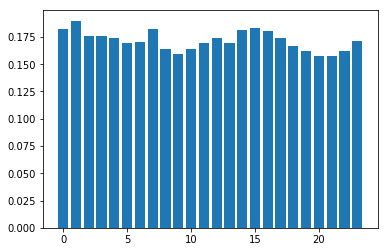

In [12]:
train_data_treated['isfraud'] = train_data_treated['isfraud'].astype(int)
frauds_by_hour_of_day = train_data_treated[['hour_of_day', 'isfraud']].groupby(by='hour_of_day').mean()
frauds_by_hour_of_day.index
plt.bar(frauds_by_hour_of_day.index, frauds_by_hour_of_day['isfraud'])
plt.show()

### Day

In [17]:
train_data_treated['day'] = [dt.day for dt in datetime]
train_data_treated['day'].value_counts(sort=False)

21    4122995
22    5337126
23    3870752
24    3335302
25    3363122
26    3835892
27    3225010
28    5279325
Name: day, dtype: int64

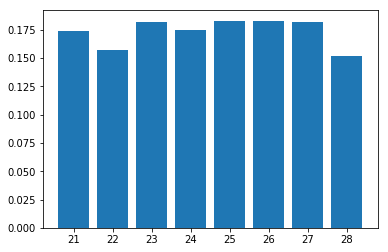

In [18]:
frauds_by_day = train_data_treated[['day', 'isfraud']].groupby(by='day').mean()
frauds_by_day.index
plt.bar(frauds_by_day.index, frauds_by_day['isfraud'])
plt.show()

## Product
* Almost every department is linked to a single category, which makes the category information very redundant when using the department.
* ID's in average are linked to 2.75 different `department_category` combinations, separating the ID information from this combination would also result in a lot of redudancy.
* Therefore, it is best to use the concatenated `cat_dep_id` attribute
* Different product categories have different fraud rates, hence it would probably be useful to encode them by fraud probability

In [102]:
%autoreload
from include.CreateConcatAtt import CreateConcatAtt
CreateConcatAtt(['product_category', 'product_department', 'product_id'], attr_name='cat_dep_id', min_rel_freq=1e-3, order_by_class=True).fit(train_data, train_data['isfraud'])

{'28905ebd-1fbe01fe-f3845767': 0.20915567907769914, 'Other': 0.16357251869563005, 'f028772b-d6137915-bb1ef334': 0.23929940926520882, 'f028772b-e151e245-7e091613': 0.2958104719856571, 'f028772b-9e8cf15d-0d3cb7be': 0.03405676636112678, '50e219e0-85f751fd-c4e18dd6': 0.11722047800227528, 'f028772b-d9750ee7-98572c79': 0.2796925338260802, '3e814130-543a539e-c7ca3108': 0.06764079736791175, 'f66779e6-6ec06dbd-d262cf1e': 0.011787091885934702, 'f028772b-0eb72673-d2f72222': 0.10219983286449076, 'f028772b-5ee41ff2-17d996e6': 0.33402551271921826, 'f028772b-6256f5b4-28f93029': 0.17791790800392968, 'f028772b-e023ba3e-75f9ddc3': 0.24149938844521188, '3e814130-5b08c53b-7687a86e': 0.4699913811344904, 'f028772b-856e6d3f-58a89a43': 0.043639667627241134, 'f028772b-83a0ad1a-5c9ae867': 0.08683086547343583, '28905ebd-f9c69707-e16ceb4b': 0.5072408681439812, 'f028772b-b7e9786d-b12b9f85': 0.0759588363217493, '28905ebd-43d6df75-27e3c518': 0.0859418141657221, '28905ebd-bb4524e7-d733bbc3': 0.06900461197153035, 'f02

CreateConcatAtt(attr_name='uo',
        attributes=['product_category', 'product_department', 'product_id'],
        copy=True, min_rel_freq=0.001, order_by_class=True)

In [ ]:
%autoreload
from include.ConcatEncoder import ConcatEncoder
encoder = ConcatEncoder(['product_category', 'product_department', 'product_id'], attr_name='cat_dep_id', min_rel_freq=1e-4, order_by_class=True, drop_old=False)
encoder.fit(train_data, train_data['isfraud'])

In [ ]:
encoder.transform(train_data)

In [100]:
a = [(1,2),(3,4)]
[x[0] for x in a]

[1, 3]

In [50]:
#rel_vc = train_data['product_category'].value_counts() / train_data.shape[0]
rel_vc
for idx, rel_freq in enumerate(rel_vc):
    if rel_freq < 1e-3:
        n = idx
        break
list(rel_vc[:n].index)

['50e219e0',
 'f028772b',
 '28905ebd',
 '3e814130',
 'f66779e6',
 '75fa27f6',
 '335d28a8',
 '76b2941d',
 'c0dd3be3']

In [51]:
a=[1,2,3,1,2,4,1,0]
list(set(a))

[0, 1, 2, 3, 4]

In [25]:
len(train_data['product_category'].value_counts())

26

In [26]:
len(train_data['product_department'].value_counts())

4551

In [29]:
category_department = pd.Series([a + '-' + b for a, b in zip(train_data['product_category'], train_data['product_department'])])
len(category_department.value_counts())

4552

In [27]:
len(train_data['product_id'].value_counts())

7298

In [28]:
category_department_id = pd.Series([a + '-' + b + '-' + c for (a, b), c in zip(zip(train_data['product_category'], train_data['product_department']), train_data['product_id'])])
len(category_department_id.value_counts())

20036

In [30]:
20036 / 7298

2.745409701288024

In [82]:
d = {}
a = [1,2,3,4,5,6,1]
for x in a:
    if x not in d:
        d[x]=[]
    else:
        d[x].append(1)
[x: 1 for x in a]

SyntaxError: invalid syntax (<ipython-input-82-43e7ae3cc4db>, line 8)

                   isfraud
product_category          
0569f928          0.052671
110ab22d          0.000000
28905ebd          0.211467
335d28a8          0.096785
3e814130          0.283193
42a36e14          0.230314
50e219e0          0.127591
5378d028          0.094972
6432c423          0.000000
70fb0e29          0.133307
72722551          0.064113
74073276          0.166667
75fa27f6          0.122760
76b2941d          0.035200
8fd0aea4          0.068548
9ccfa2ea          0.012987
a72a0145          0.000000
a818d37a          0.003557
bcf865d9          0.046512
c0dd3be3          0.118193
c706e647          0.000000
da34532e          0.000000
dedf689d          0.488356
e787de0e          0.071867
f028772b          0.179738
f66779e6          0.040317


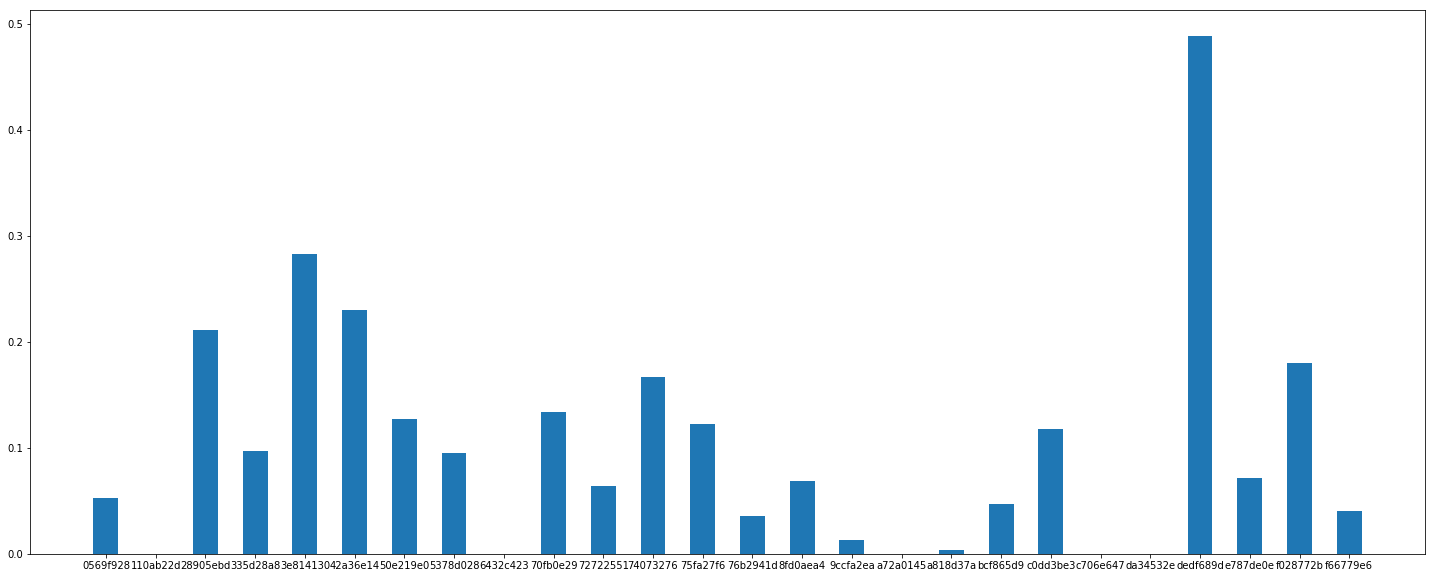

In [69]:
frauds_by_category = train_data[['product_category', 'isfraud']].groupby(by='product_category').mean()
plt.figure(figsize=(25,10))
plt.bar(frauds_by_category.index, frauds_by_category['isfraud'], width=0.5)
plt.show()

# Observing frauds

In [18]:
#a = train_data['user_id'].value_counts() 
a[a < 30]

4f2638e2    29
be91513c    29
ad5b1ded    29
a4d28d74    29
20419348    29
a9e5206e    29
7fce729a    29
caa5deaa    29
055acd14    29
1202cb62    29
79adbec1    29
b3e76e2e    29
fe6fe698    29
eff814d1    29
a2d145f0    29
03f85ebf    29
dd2ec838    29
fd222dd5    29
06239d2e    29
ce320dcb    29
cfe68cae    29
633dc08e    29
cb48f81d    29
cdb60770    29
09586b29    29
5d2df384    29
251c97ce    29
92454a51    29
b1e57fbd    29
d3490bf4    29
            ..
6f7ba7ea     1
62a60475     1
3b34d54d     1
899aecba     1
3bd06402     1
cb30953a     1
b233ebf5     1
30dfe019     1
477066d5     1
0150088a     1
ede6af8f     1
987f1763     1
c71201e5     1
166e4b03     1
22f32cb7     1
d2ead847     1
4157c3b2     1
38c71af5     1
a6c29266     1
a6c61e60     1
05d62b17     1
9c8dbea1     1
3707bc8f     1
48dee450     1
7082ea3f     1
af74d90f     1
91829dd8     1
56d29f30     1
62274dfb     1
355cddd7     1
Name: user_id, Length: 2205396, dtype: int64

In [19]:
train_data[train_data['user_id'] == '4f2638e2']

,id,timestamp,product_id,product_department,product_category,card_id,user_id,C15,C16,C17,C18,C19,C20,C21,amount,isfraud
2592636,2592636,1413894585084,8eb11125,39cffaa4,50e219e0,ecad2386,4f2638e2,320,50,2253,2,303,-1,52,149.06,0
2603166,2603166,1413899086392,e8cab48f,f17ebd97,50e219e0,ecad2386,4f2638e2,320,50,2253,2,303,-1,52,217.06,0
2666638,2666638,1413897322452,e8cab48f,f17ebd97,50e219e0,ecad2386,4f2638e2,320,50,2253,2,303,-1,52,217.06,0
6599112,6599112,1413975324564,e8cab48f,f17ebd97,50e219e0,ecad2386,4f2638e2,320,50,2476,2,167,-1,23,217.06,0
6646930,6646930,1413973524420,e8cab48f,f17ebd97,50e219e0,ecad2386,4f2638e2,320,50,2476,2,167,-1,23,217.06,0
26412721,26412721,1414435576305,19944fab,c6af341d,50e219e0,ecad2386,4f2638e2,320,50,2512,2,291,-1,52,209.97,0
29584925,29584925,1414498610271,c4e18dd6,c6af341d,50e219e0,ecad2386,4f2638e2,320,50,2512,2,291,-1,52,209.97,1
31210869,31210869,1414518736706,5888d1c7,f17ebd97,50e219e0,ecad2386,4f2638e2,320,50,2684,2,1327,-1,52,217.06,0
31251551,31251551,1414516865868,5888d1c7,f17ebd97,50e219e0,ecad2386,4f2638e2,320,50,2684,2,1327,-1,52,217.06,0
31306053,31306053,1414517602507,5888d1c7,f17ebd97,50e219e0,ecad2386,4f2638e2,320,50,2684,2,1327,-1,52,217.06,0
